In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as mno
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from pandas_profiling import ProfileReport
import phik

In [3]:
df = pd.read_csv("train.csv", index_col="id")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
df.shape

(103904, 23)

In [5]:
df.dtypes

Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

In [6]:
cat_columns = [0, 1, 3, 4] + list(range(6, 20))
df.iloc[:, cat_columns] = df.iloc[:, cat_columns].astype("category")

In [7]:
df.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103594.000000
mean,39.379706,1189.448375,14.815618,15.178678
std,15.114964,997.147281,38.230901,38.698682
min,7.000000,31.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000
50%,40.000000,843.000000,0.000000,0.000000
75%,51.000000,1743.000000,12.000000,13.000000
max,85.000000,4983.000000,1592.000000,1584.000000


In [8]:
df.describe(include="category")

,Gender,Customer Type,Type of Travel,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
count,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904
unique,2,2,2,3,6,6,6,6,6,6,6,6,6,6,5,6,6,6
top,Female,Loyal Customer,Business travel,Business,3,4,3,3,4,4,4,4,4,4,4,4,4,4
freq,52727,84923,71655,49665,25868,25546,24449,28577,24359,30762,31765,29423,30867,28789,37383,29055,37945,27179


In [9]:
df.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

# Data Cleaning

## Missing Values

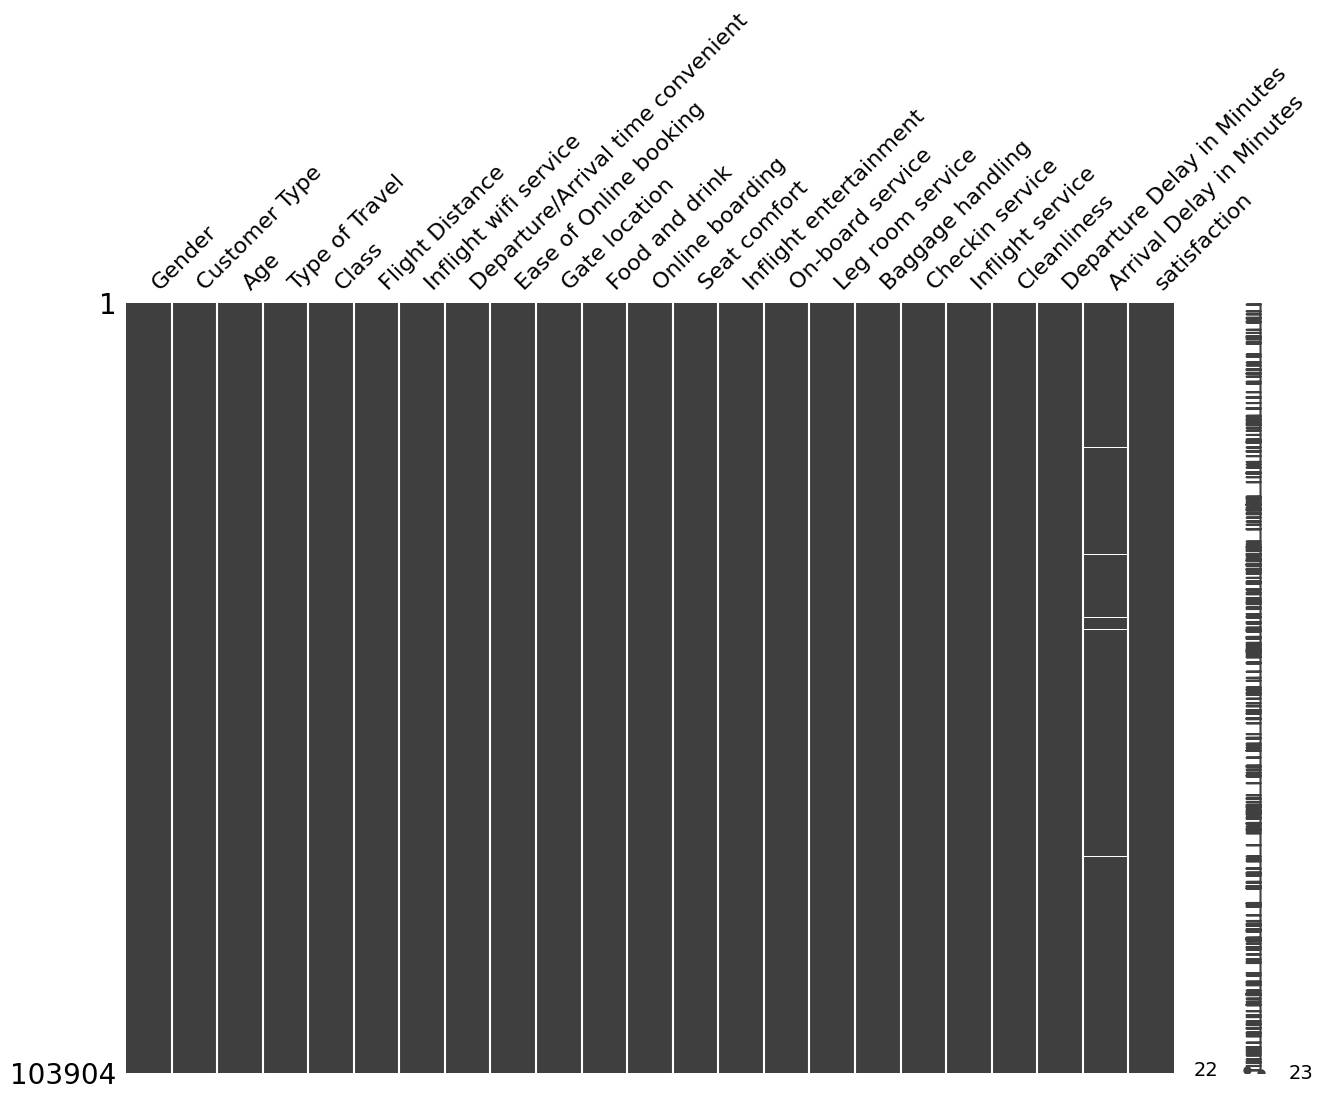

In [10]:
mno.matrix(df, figsize=(15, 10));

## Using Regression to fill in missing values

In [11]:
training_data = df.dropna()
training_data_X = training_data.drop(["Arrival Delay in Minutes"], axis=1)
training_data_y = training_data["Arrival Delay in Minutes"]

In [12]:
nominal_X_cols = ["Gender", "Customer Type", "Type of Travel", "Class", "satisfaction"]
numerical_X_cols = ["Flight Distance", "Departure Delay in Minutes"]
ct = ColumnTransformer([("nominal_preprocess", OneHotEncoder(), nominal_X_cols),
                           ("num_preprocess", StandardScaler(), numerical_X_cols),
                           ("age_preprocess", KBinsDiscretizer(n_bins=10, encode="ordinal"), ["Age"])], remainder="passthrough")

In [13]:
lin_reg = Pipeline([("ct", ct), ("lin_reg", LinearRegression())])
r2s = cross_val_score(lin_reg, training_data_X, training_data_y)
print(f"Mean R2 = {r2s.mean():.4f}")
lin_reg.fit(training_data_X, training_data_y)

Mean R2 = 0.9322


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal_preprocess',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Customer Type',
                                                   'Type of Travel', 'Class',
                                                   'satisfaction']),
                                                 ('num_preprocess',
                                                  StandardScaler(),
                                                  ['Flight Distance',
                                                   'Departure Delay in '
                                                   'Minutes']),
                                                 ('age_preprocess',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=10),
                                                  ['Age'])])),
                ('lin_reg', LinearRegression())])

In [14]:
missing_mask = df["Arrival Delay in Minutes"].isna()
values = lin_reg.predict(df.drop(["Arrival Delay in Minutes"], axis=1)[missing_mask])
df["Arrival Delay in Minutes"][missing_mask] = values

In [15]:
values[values < 0]

array([-0.07495117, -0.05810547, -0.34985352, -0.45629883, -0.39892578,
       -0.11743164, -0.16088867])

There are 7/310 predicted values which are negative. I will give these values of 0

In [16]:
df["Arrival Delay in Minutes"] = df["Arrival Delay in Minutes"].clip(lower=0)

### Outliers

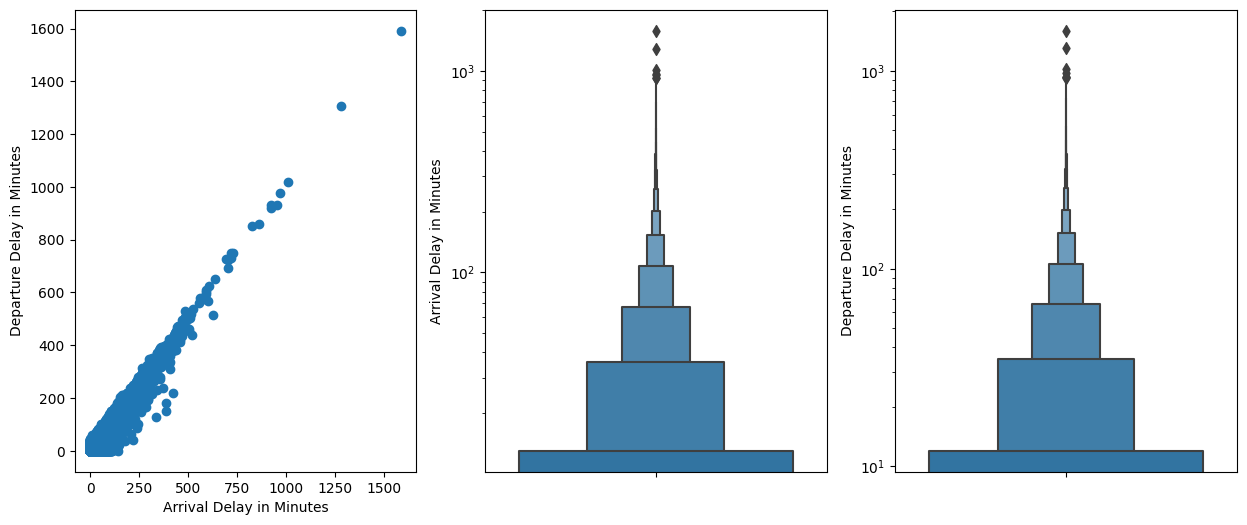

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))

axs[0].scatter(df["Arrival Delay in Minutes"], df["Departure Delay in Minutes"])
axs[0].set_xlabel("Arrival Delay in Minutes")
axs[0].set_ylabel("Departure Delay in Minutes")
sns.boxenplot(y=df["Arrival Delay in Minutes"], ax=axs[1])
sns.boxenplot(y=df["Departure Delay in Minutes"], ax=axs[2]);
axs[1].set_yscale("log")
axs[2].set_yscale("log")

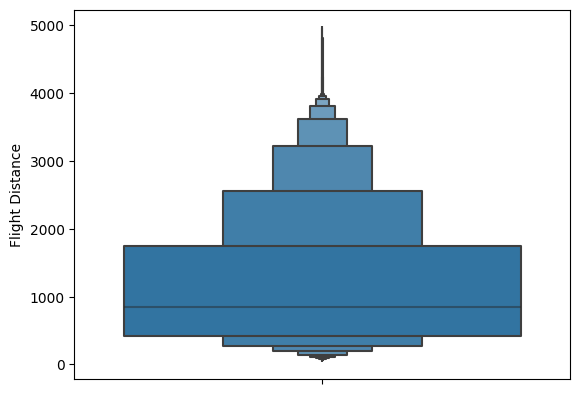

In [18]:
sns.boxenplot(y=df["Flight Distance"]);

### Correlation Analysis

In [19]:
df.corr(method="pearson")

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
Age,1.000000,0.099461,-0.010152,-0.012149
Flight Distance,0.099461,1.000000,0.002158,-0.002170
Departure Delay in Minutes,-0.010152,0.002158,1.000000,0.965773
Arrival Delay in Minutes,-0.012149,-0.002170,0.965773,1.000000


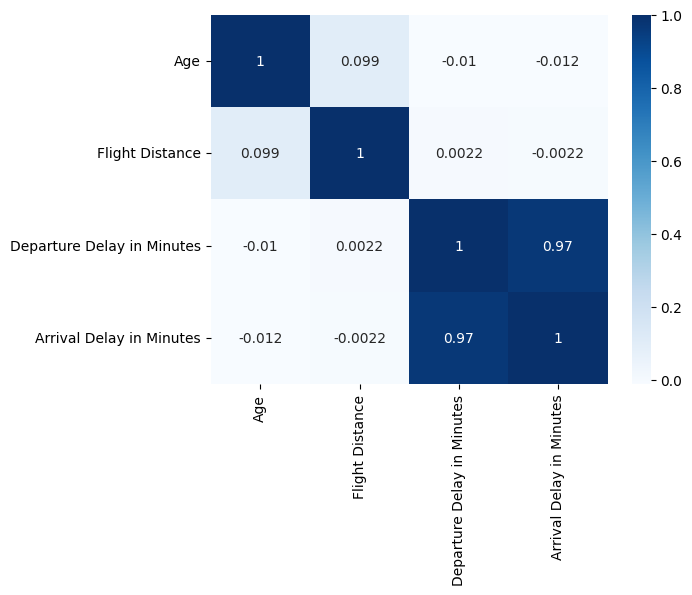

In [20]:
sns.heatmap(df.corr(), annot=True, cmap="Blues");

interval columns not set, guessing: ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']


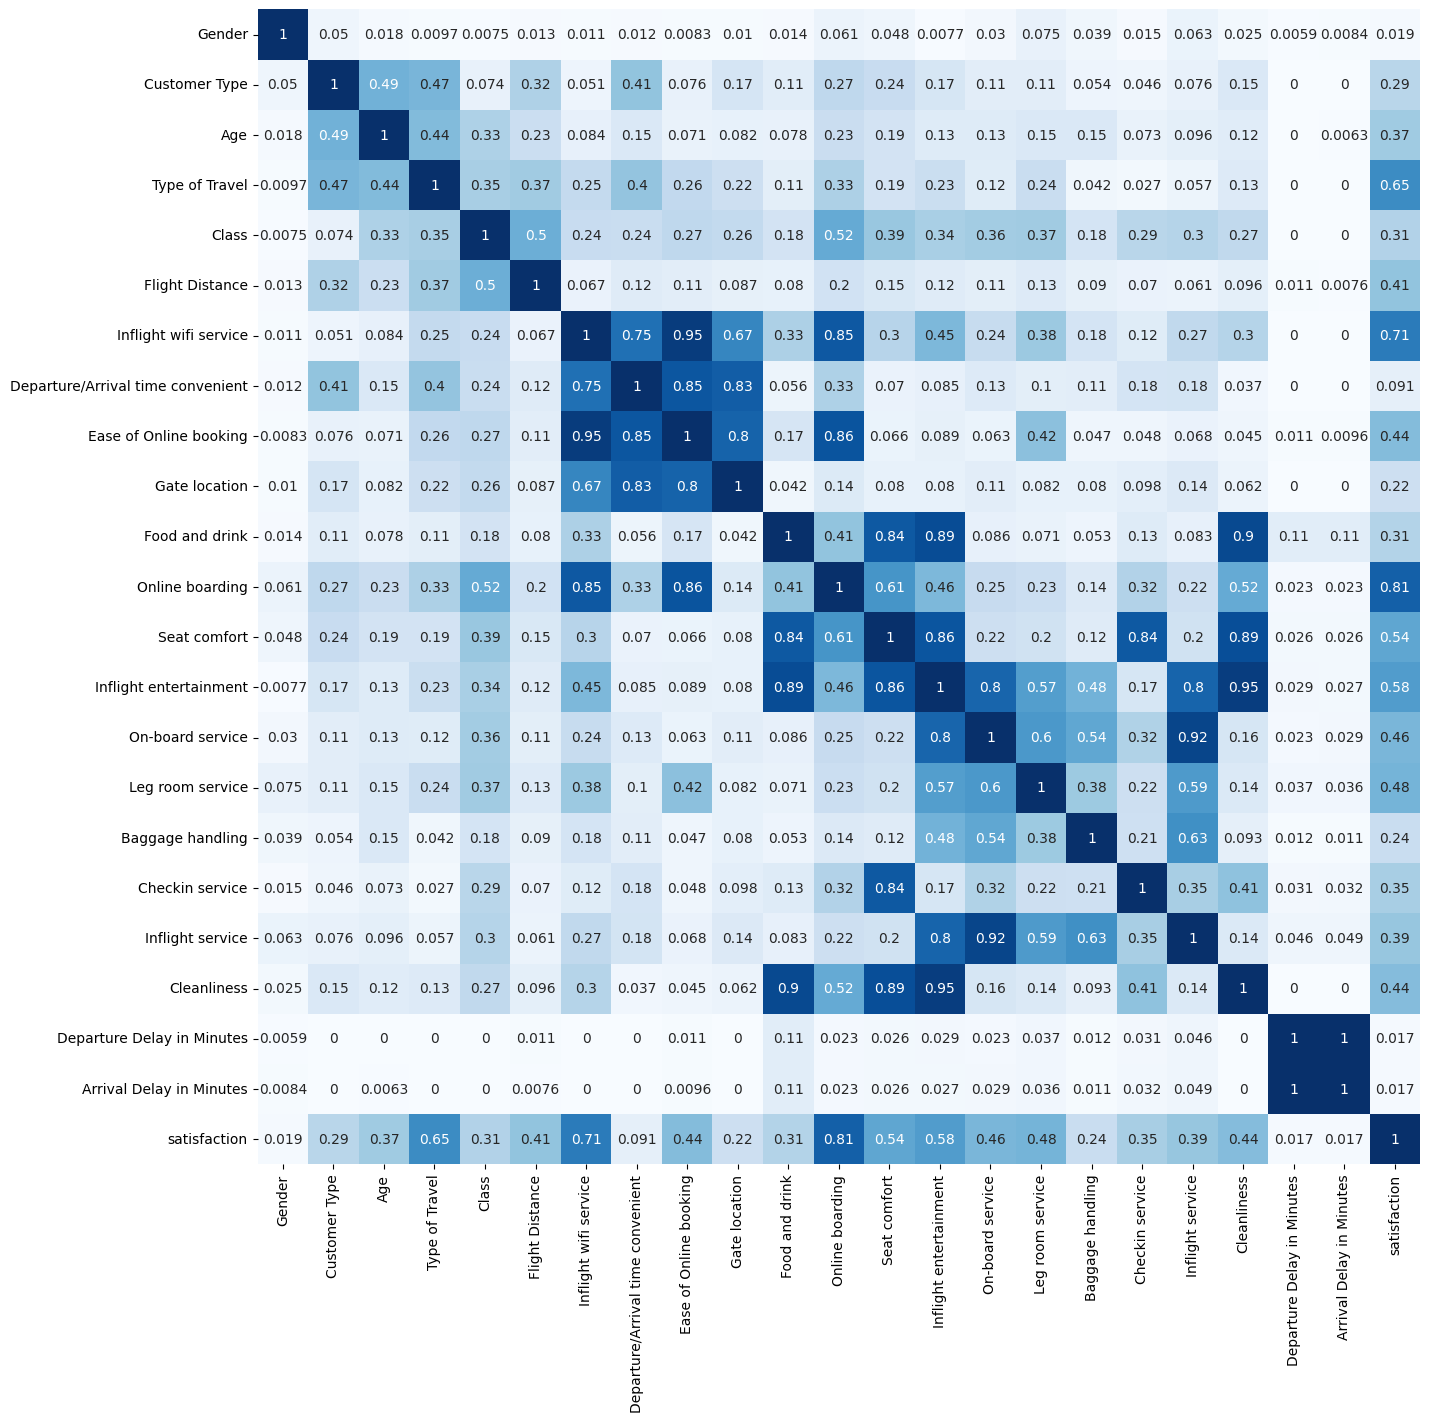

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
phik_corr = df.phik_matrix()
sns.heatmap(phik_corr, cmap="Blues", annot=True, ax=ax, cbar=False);

# Data Visualization

In [22]:
df_copy = df.copy()

# Numerical Features

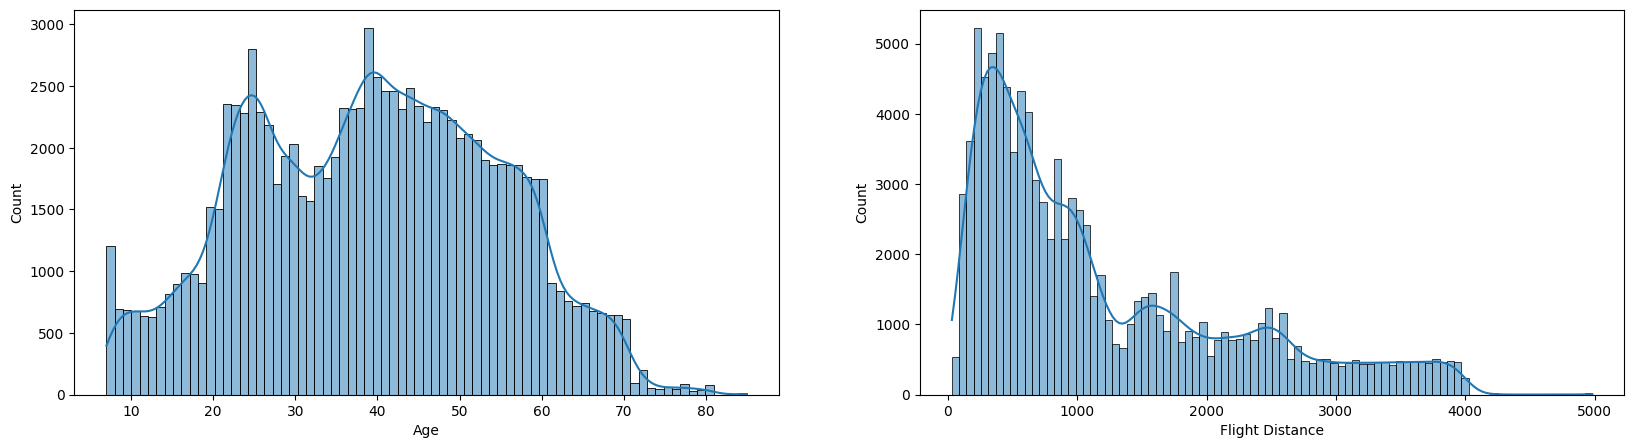

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(x=df_copy["Age"], kde=True, ax = axs[0]);
sns.histplot(x=df_copy["Flight Distance"], kde=True, ax = axs[1]);

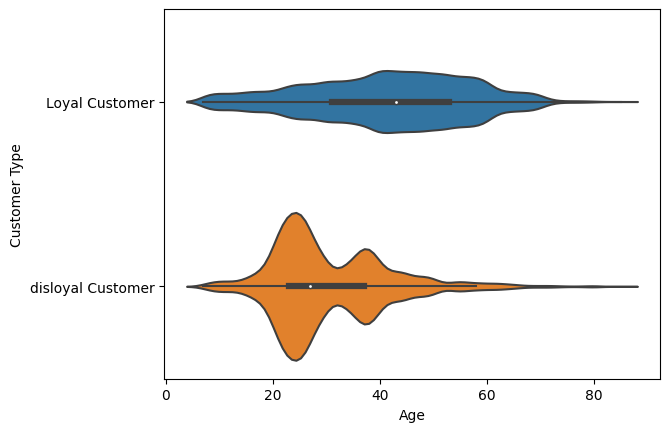

In [24]:
sns.violinplot(data=df_copy, x="Age", y="Customer Type");

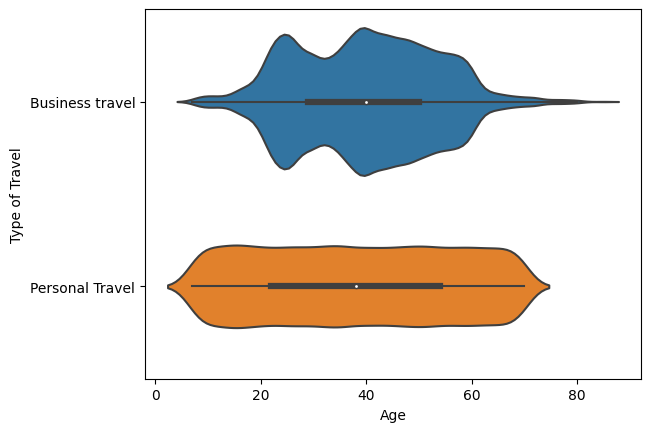

In [25]:
sns.violinplot(data=df_copy, x="Age", y="Type of Travel");

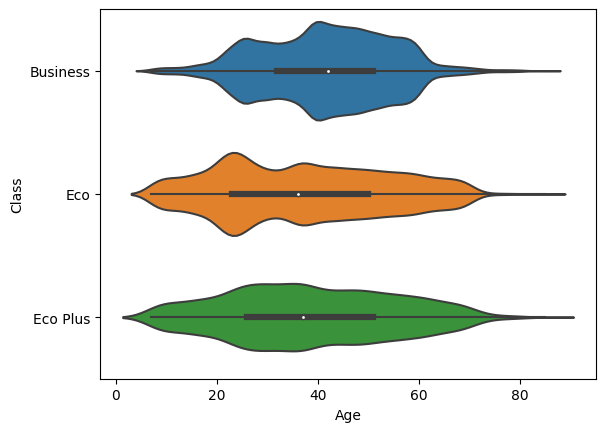

In [26]:
sns.violinplot(data=df_copy, x="Age", y="Class");

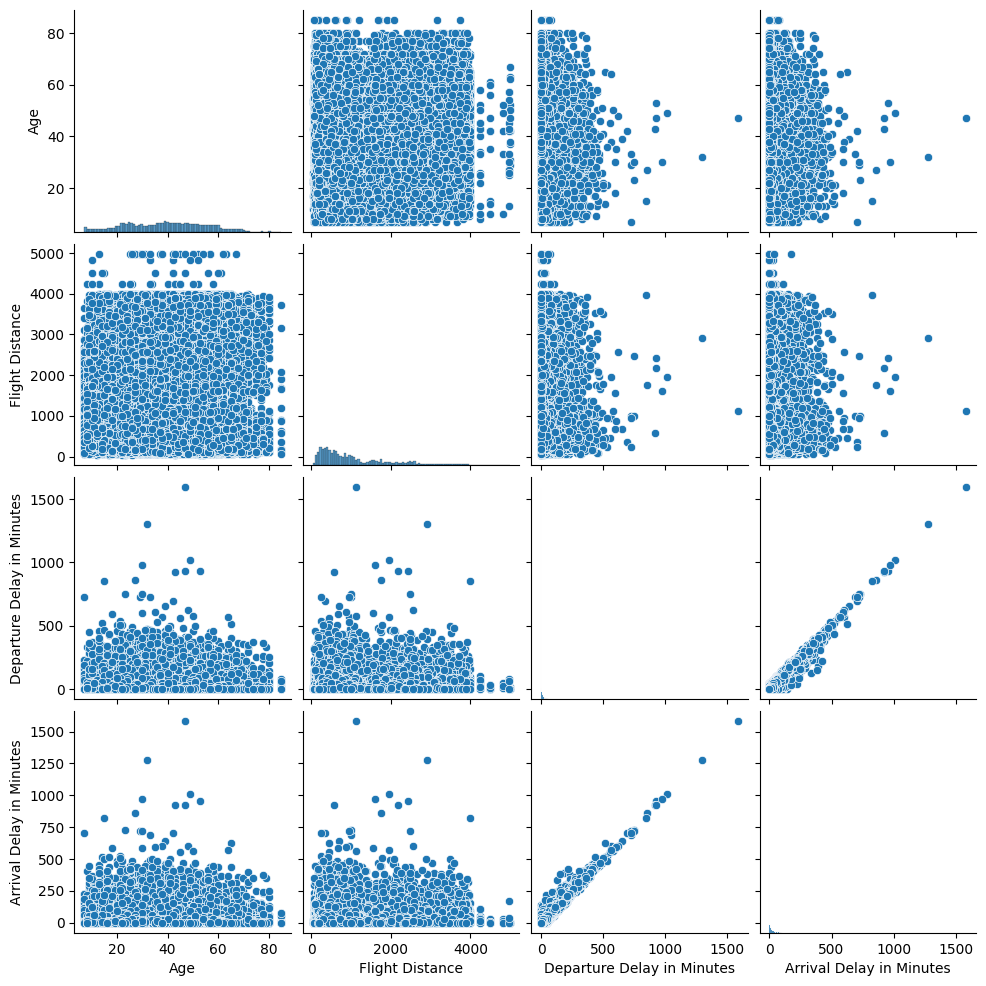

In [27]:
sns.pairplot(data=df_copy);

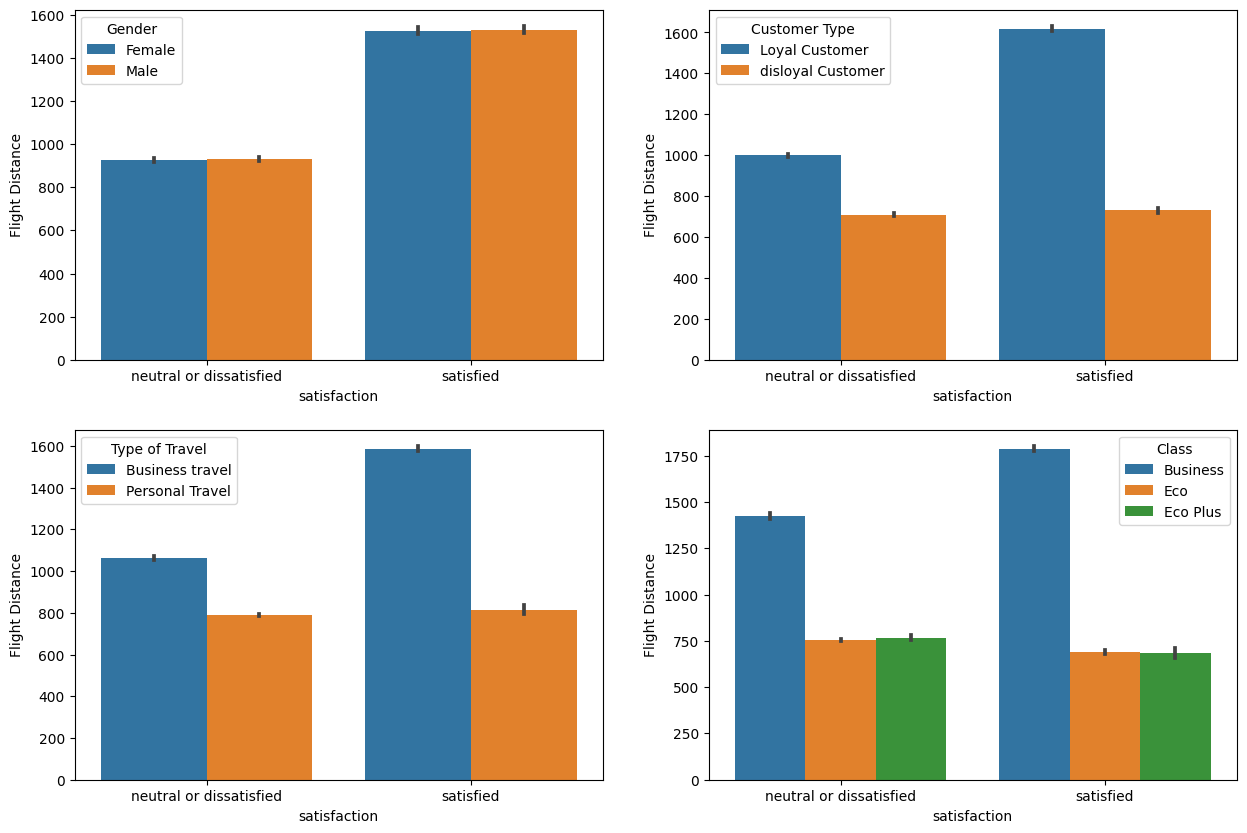

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
nominal_cols = ["Gender", "Customer Type", "Type of Travel", "Class"]
for i, col in enumerate(nominal_cols):
    sns.barplot(data=df_copy, x="satisfaction", y="Flight Distance", hue=col, ax=axs.flatten()[i])

# Nominal Features

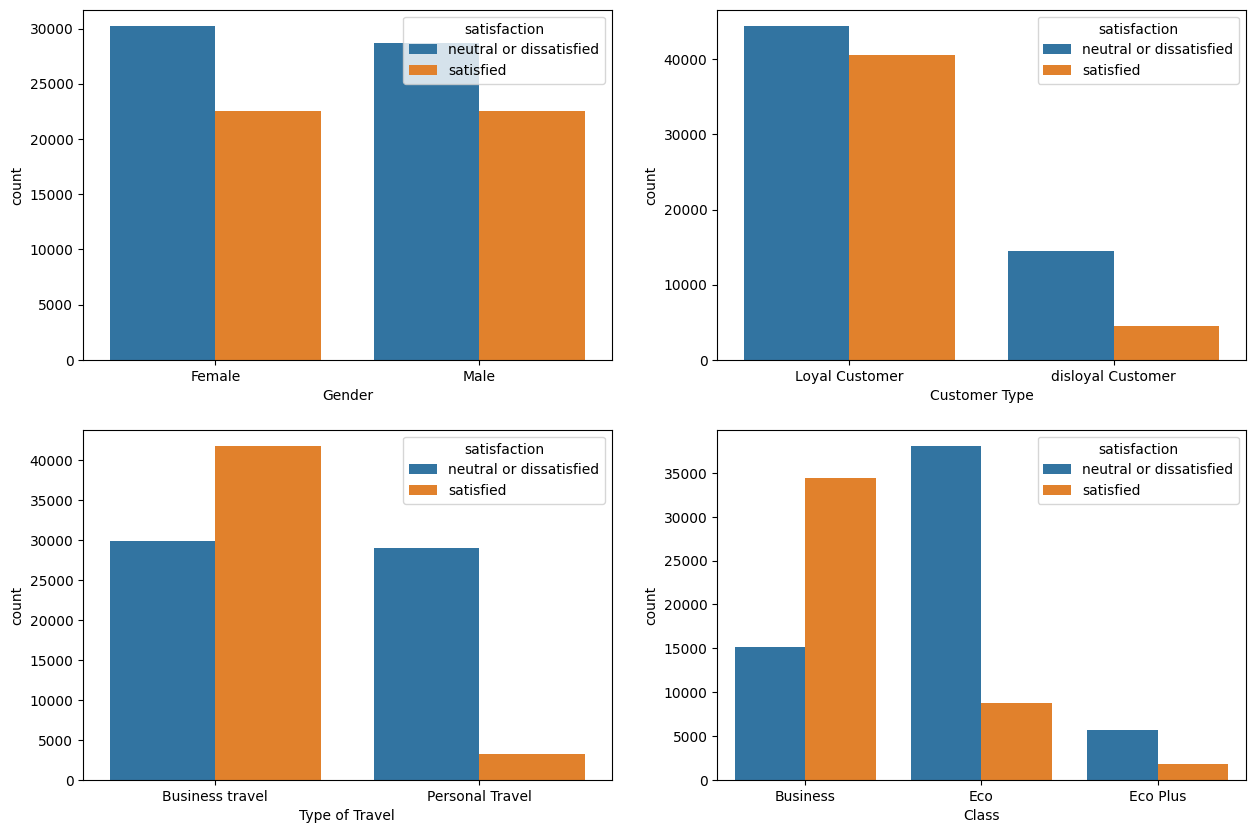

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
for i, col in enumerate(nominal_cols):
    sns.countplot(data=df_copy, x=col, hue="satisfaction", ax=axs.flatten()[i])

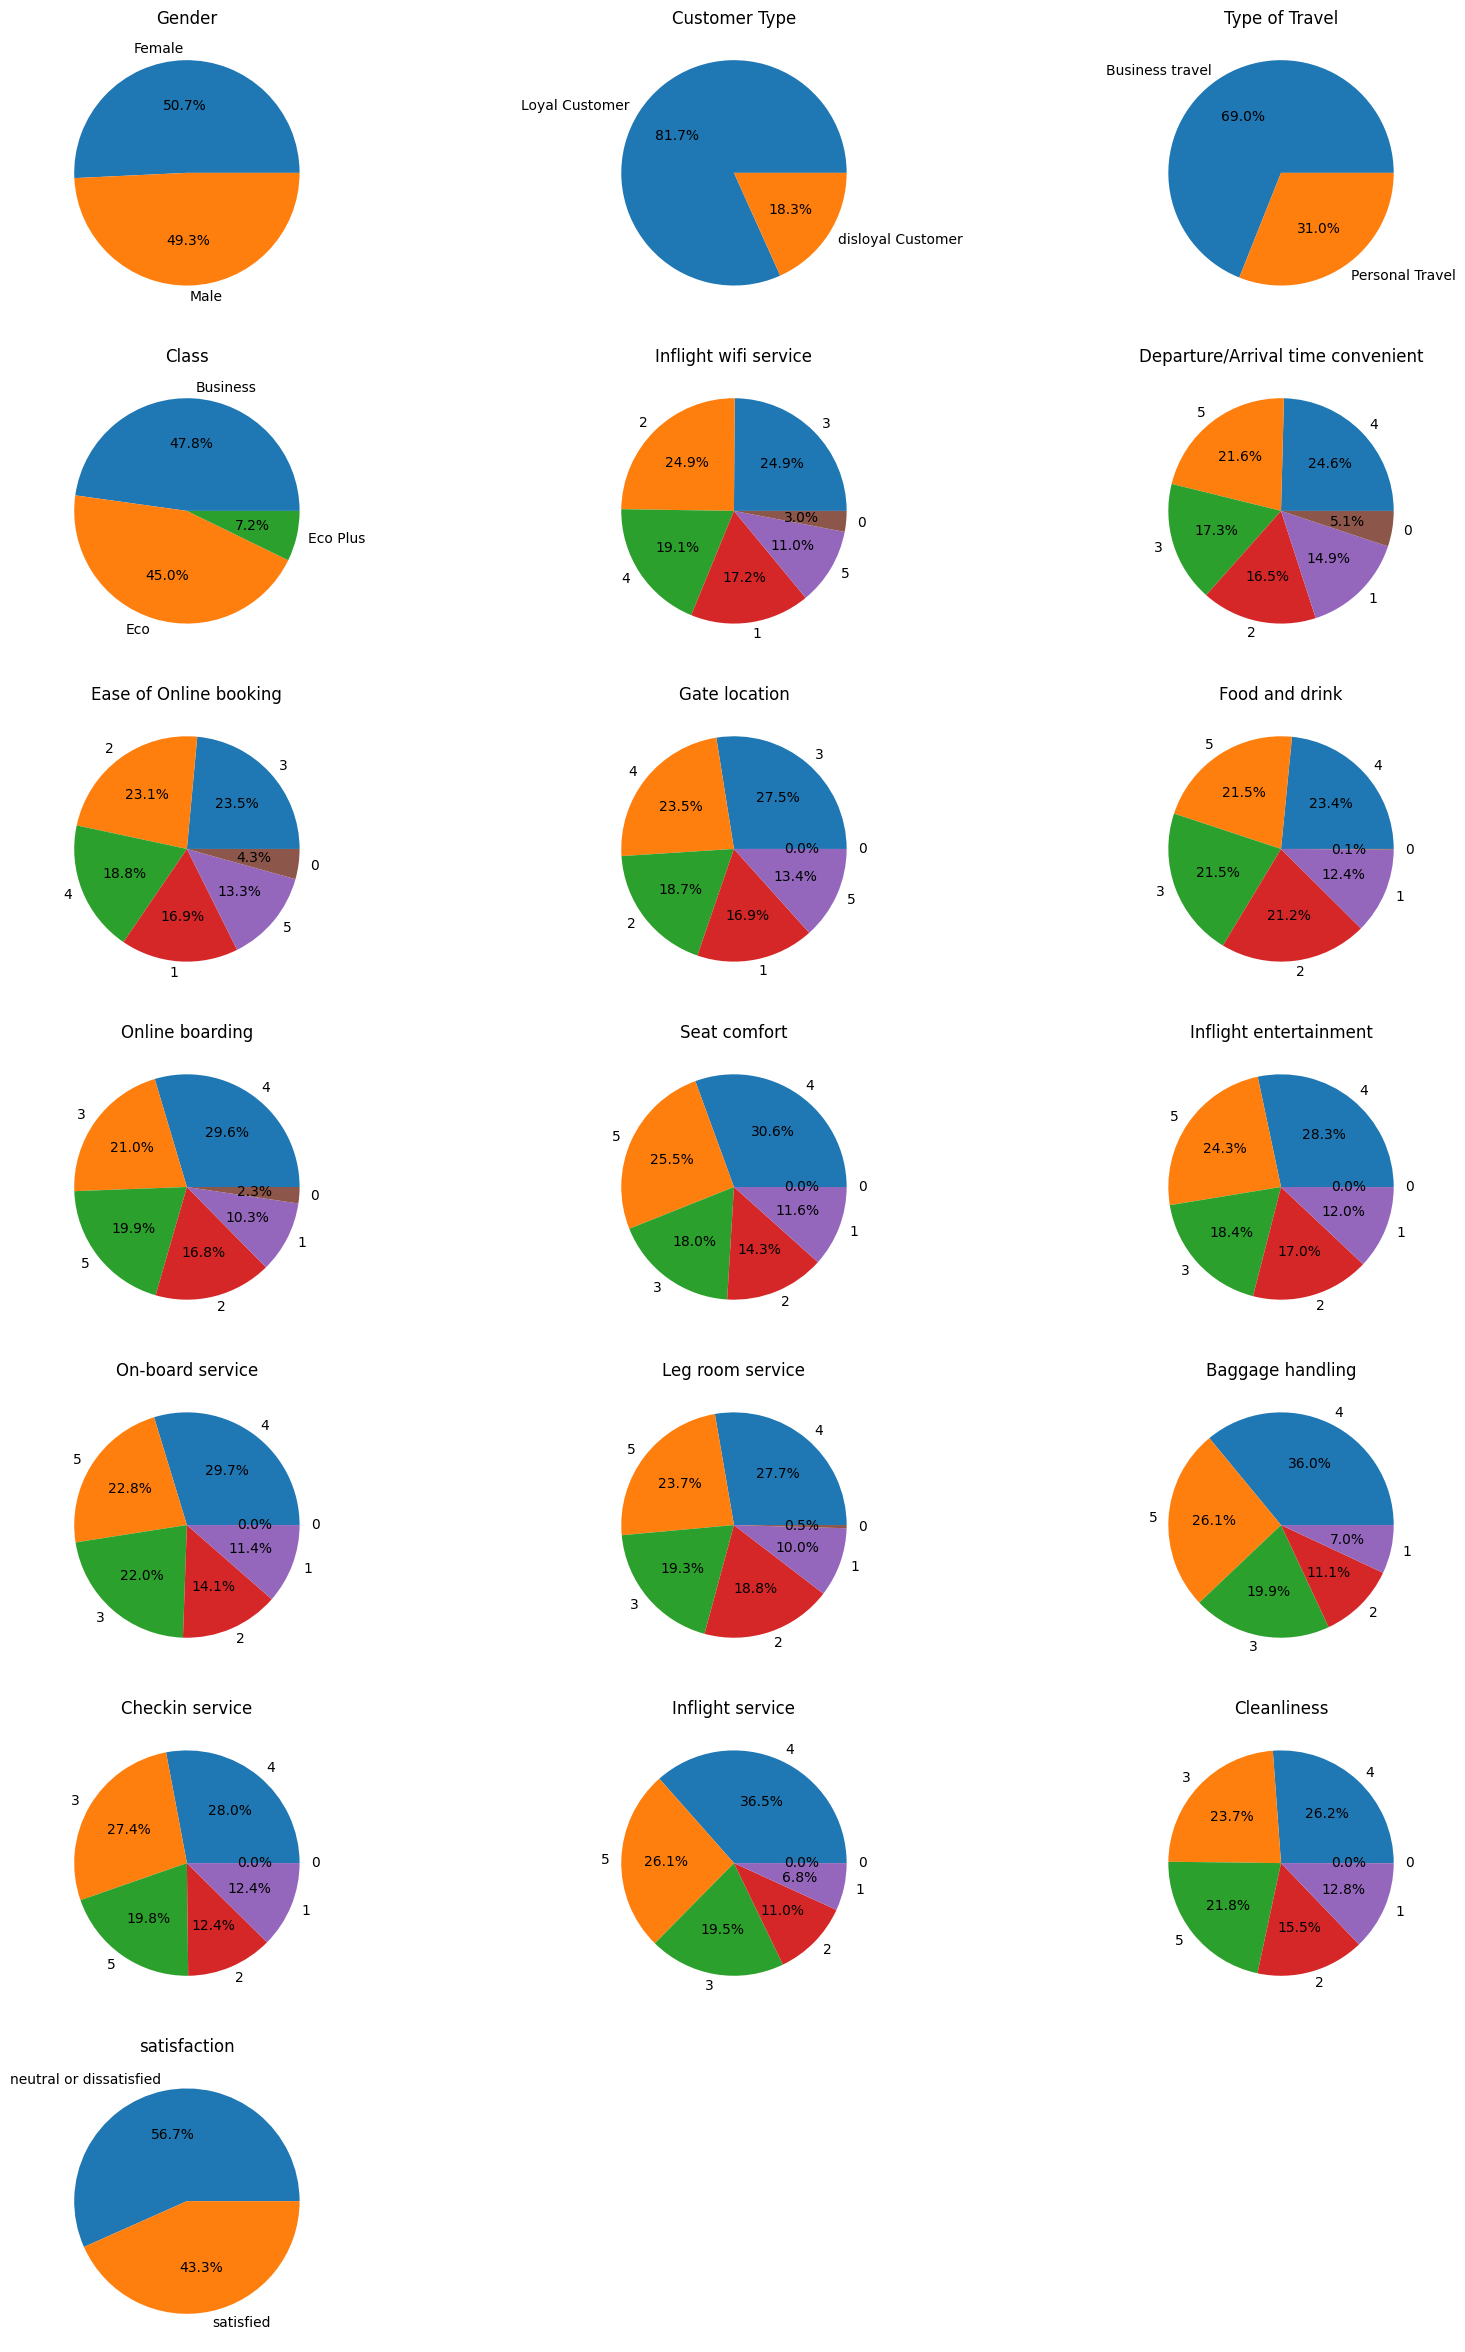

In [30]:
cat_cols = [col for col in df_copy.columns if df_copy[col].dtype == "category"] + ["satisfaction"]
fig, axs = plt.subplots(7, 3, figsize=(20, 30))
fig.delaxes(axs[6,2])
fig.delaxes(axs[6,1])

for idx, col in enumerate(cat_cols):
    ax = axs.flatten()[idx]
    sizes = df_copy[col].value_counts()
    ax.pie(sizes, labels=sizes.index, autopct='%1.1f%%')
    ax.set_title(col)

# Classification

In [23]:
def plot_confusion_matrix(model):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model[-1].classes_)
    cm_display.plot(ax=ax[0], cmap="Blues", colorbar=False, values_format="d")
    ax[0].set_title(f"{model[-1].__class__.__name__}")
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[1])

In [24]:
def display_test_metrics(best_models):
    report_data = []
    for j, model in enumerate(best_models):
        y_pred = model.predict(X_test)
        report = {}
        report["Classifier"] = f"{model[-1].__class__.__name__}"
        report["Accuracy"] = accuracy_score(y_test, y_pred)
        report["Precision"] = precision_score(y_test, y_pred, pos_label="satisfied")
        report["Recall"] = recall_score(y_test, y_pred, pos_label="satisfied")
        report["F1"] = f1_score(y_test, y_pred, pos_label="satisfied")
        try:
            report["AUC"] = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        except AttributeError:
            report["AUC"] = roc_auc_score(y_test, model.decision_function(X_test))
        report_data.append(report)
    df = pd.DataFrame(report_data).set_index("Classifier")
    df = df.round(4)
    fig1 = plt.figure(figsize = (8, len(best_models)/10))
    ax = fig1.add_subplot(111)
    ax.table(cellText = df.values,
          rowLabels = df.index,
          colLabels = df.columns,
          cellLoc = "center"
         )
    ax.set_title(f"Test Metrics",
                 fontdict={'fontsize': 20,
                        'fontweight': 'bold',
                        'color': 'steelblue'},
                  loc='left')

    ax.axis("off")
    return df

In [25]:
kbd = KBinsDiscretizer(n_bins=10, encode="ordinal")
df["Binned_age"] = kbd.fit_transform(df["Age"].values.reshape(-1, 1)).astype("int")

In [26]:
X = df.drop(["satisfaction", "Age", "Arrival Delay in Minutes"], axis=1)
y = df["satisfaction"]

In [27]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)

In [28]:
nominal_X_cols = ["Gender", "Customer Type", "Type of Travel", "Class"]
numerical_X_cols = ["Flight Distance", "Departure Delay in Minutes"]
ct = ColumnTransformer([("nominal_preprocess", OneHotEncoder(), nominal_X_cols),
                           ("num_preprocess", StandardScaler(), numerical_X_cols)], remainder="passthrough")

# Deicision Tree Classifier

In [38]:
pipe = Pipeline([("ct", ct), ("dt", DecisionTreeClassifier(random_state=seed))])

param_grid = {
    "dt__criterion": ["gini", "entropy"],
    "dt__max_depth": np.arange(10, 30, 2)
}
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

dt_clf = grid.best_estimator_
index = grid.best_index_
print(f"CV Mean score: {grid.best_score_}")

{'dt__criterion': 'entropy', 'dt__max_depth': 16}
CV Mean score: 0.9536517432149771


Test Accuracy: 0.9536442961632234
                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.97      0.96     17555
              satisfied       0.96      0.93      0.95     13617

               accuracy                           0.95     31172
              macro avg       0.95      0.95      0.95     31172
           weighted avg       0.95      0.95      0.95     31172



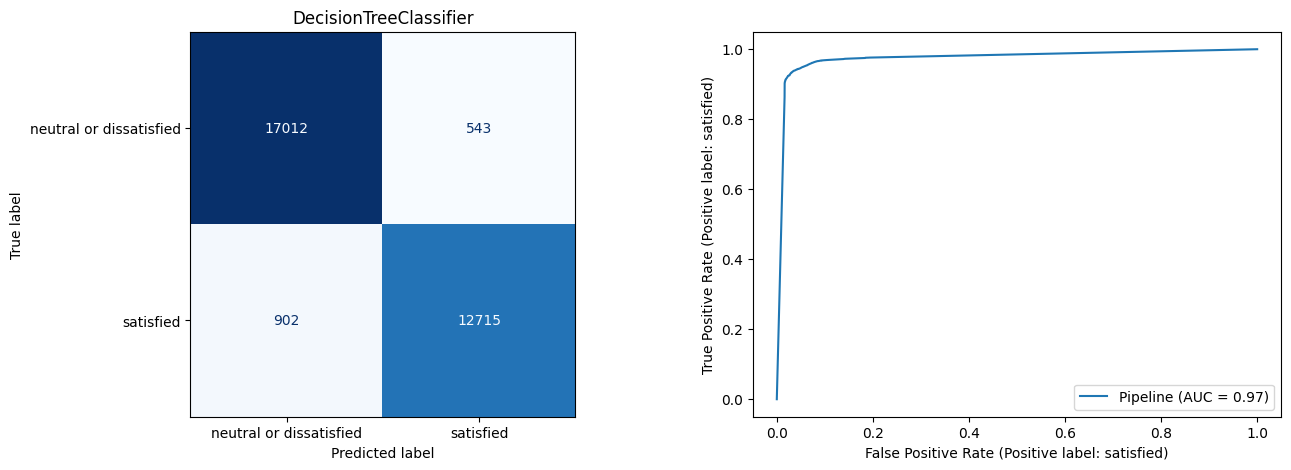

In [39]:
y_pred = dt_clf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(dt_clf)

In [40]:
column_names = np.array([col[col.index("__") + 2:] for col in dt_clf[0].get_feature_names_out()])

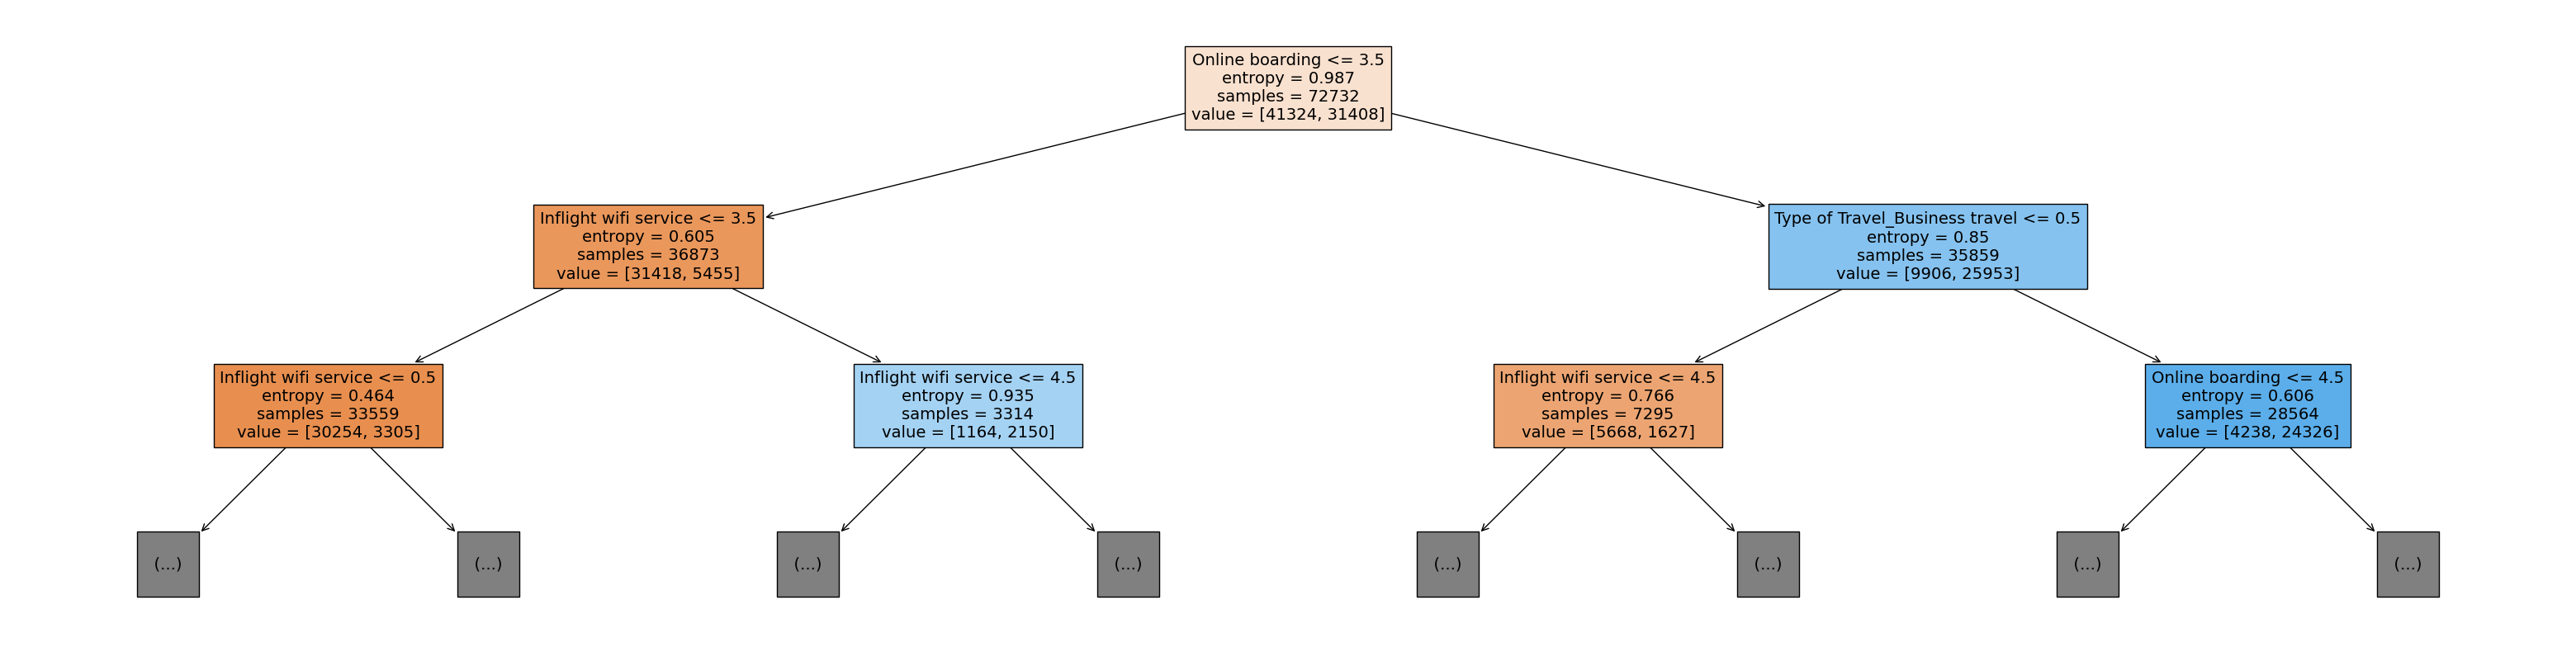

In [41]:
fig, axs = plt.subplots(1, 1, figsize=(40,10))
plot_tree(dt_clf[-1], feature_names=column_names, max_depth=2, filled=True, ax=axs);

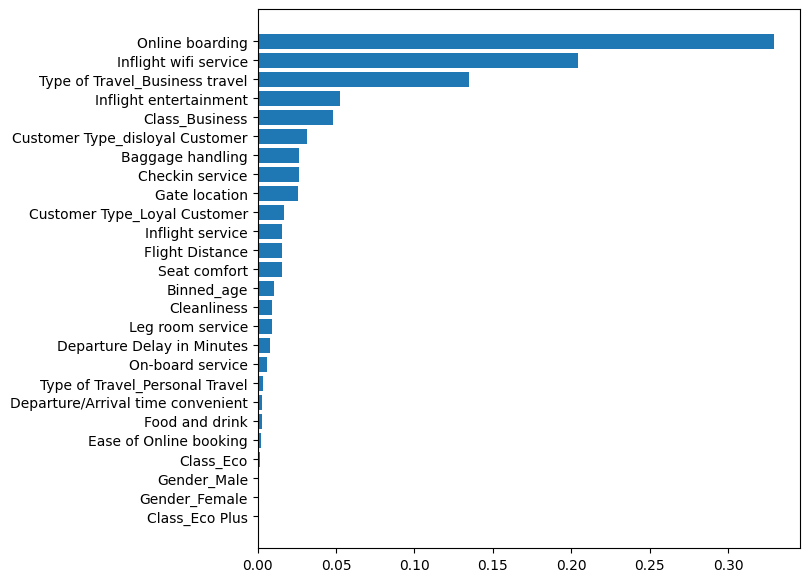

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
importance = dt_clf[-1].feature_importances_
idx = importance.argsort()
ax.barh(range(len(idx)), importance[idx])
ax.set_yticks(range(len(idx)), column_names[idx]);

# Logistic Regression

In [43]:
import warnings
warnings.filterwarnings('ignore')

pipe = Pipeline([("ct", ct), ("lr", LogisticRegression(random_state=seed, max_iter=1000))])
# scores = cross_val_score(lr_clf, X_train, y_train, cv=10)
param_grid = {
    "lr__penalty": ["l1", "l2"],
    'lr__solver': ['lbfgs', 'sag', "newton-cg"],
    "lr__C": [0.001, 0.01, 0.1, 1, 10, 100]
}
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
index = grid.best_index_
print(f"CV Mean score: {grid.best_score_}")

lr_clf = grid.best_estimator_

{'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__solver': 'newton-cg'}
CV Mean score: 0.8748006012875976


Test Accuracy: 0.8748556396766328
                         precision    recall  f1-score   support

neutral or dissatisfied       0.88      0.90      0.89     17555
              satisfied       0.87      0.84      0.85     13617

               accuracy                           0.87     31172
              macro avg       0.87      0.87      0.87     31172
           weighted avg       0.87      0.87      0.87     31172



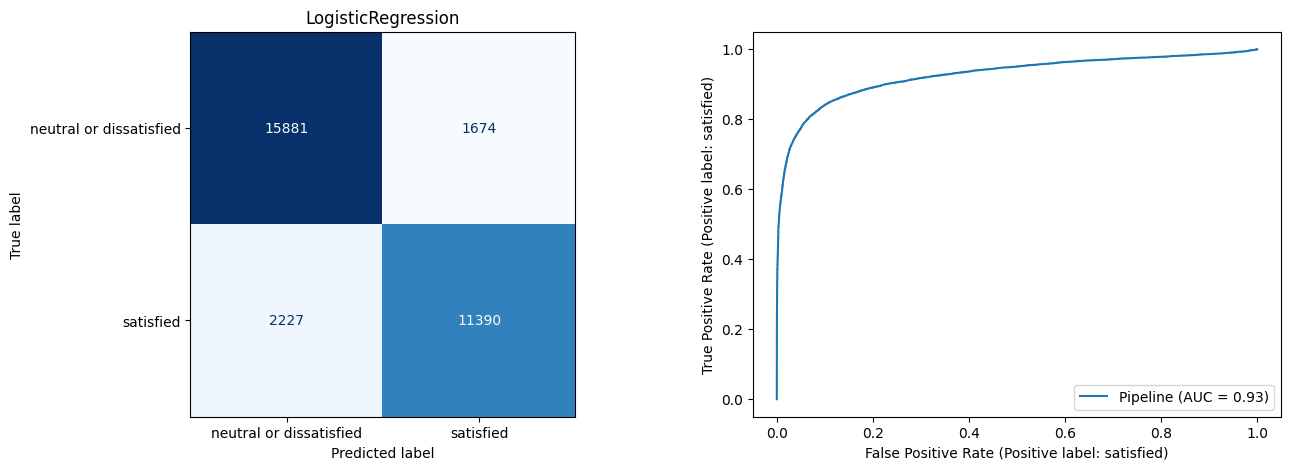

In [44]:
y_pred = lr_clf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lr_clf)

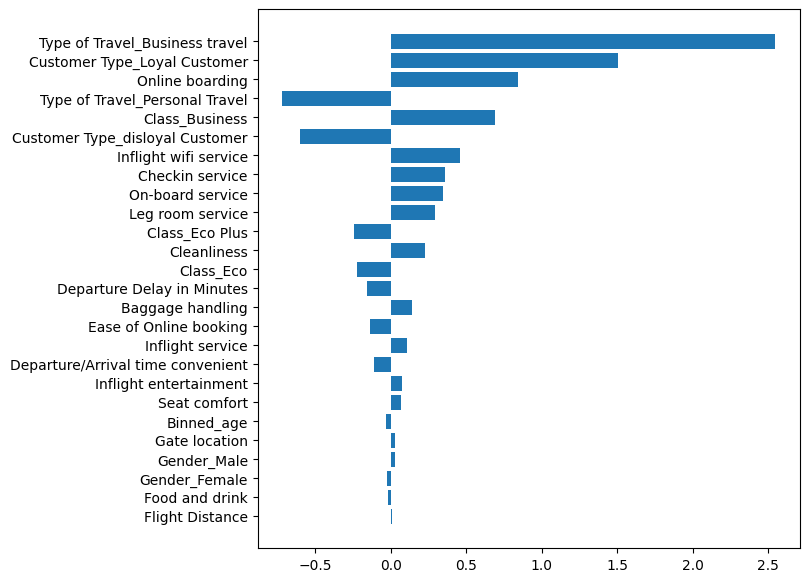

/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/linear_mode

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
logit_coef = np.exp(lr_clf[-1].coef_[0]) - 1
idx = abs(logit_coef).argsort()
ax.barh(range(len(idx)), logit_coef[idx])
ax.set_yticks(range(len(idx)), column_names[idx]);

# Naive Bayes

In [46]:
gnb = Pipeline([("ct", ct), ("gnb", GaussianNB())])
scores = cross_val_score(gnb, X_train, y_train, cv=10)
gnb.fit(X_train, y_train)
print(f"CV Mean score: {scores.mean()}")

CV Mean score: 0.8495573210409338


Test Accuracy: 0.8499935839856281
                         precision    recall  f1-score   support

neutral or dissatisfied       0.86      0.88      0.87     17555
              satisfied       0.84      0.82      0.83     13617

               accuracy                           0.85     31172
              macro avg       0.85      0.85      0.85     31172
           weighted avg       0.85      0.85      0.85     31172



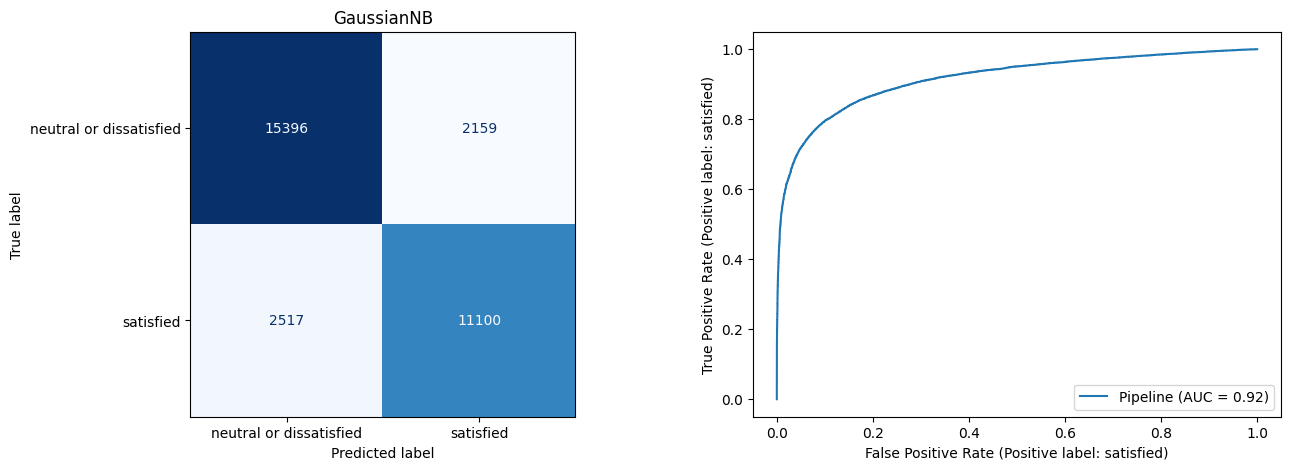

In [47]:
y_pred = gnb.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(gnb)

# KNN

In [48]:
pipe = Pipeline([("ct", ct), ("knn", KNeighborsClassifier(n_jobs=-1))])
param_grid = {
    "knn__n_neighbors": [5, 7, 9, 10, 11],
    "knn__weights": ["uniform", "distance"],
    'knn__metric': ["euclidean", "manhattan"]
}
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
index = grid.best_index_
print(f"CV Mean score: {grid.best_score_}")

knn = grid.best_estimator_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}
CV Mean score: 0.9357229580588557


Test Accuracy: 0.9363852175028872
                         precision    recall  f1-score   support

neutral or dissatisfied       0.93      0.96      0.94     17555
              satisfied       0.95      0.90      0.93     13617

               accuracy                           0.94     31172
              macro avg       0.94      0.93      0.93     31172
           weighted avg       0.94      0.94      0.94     31172



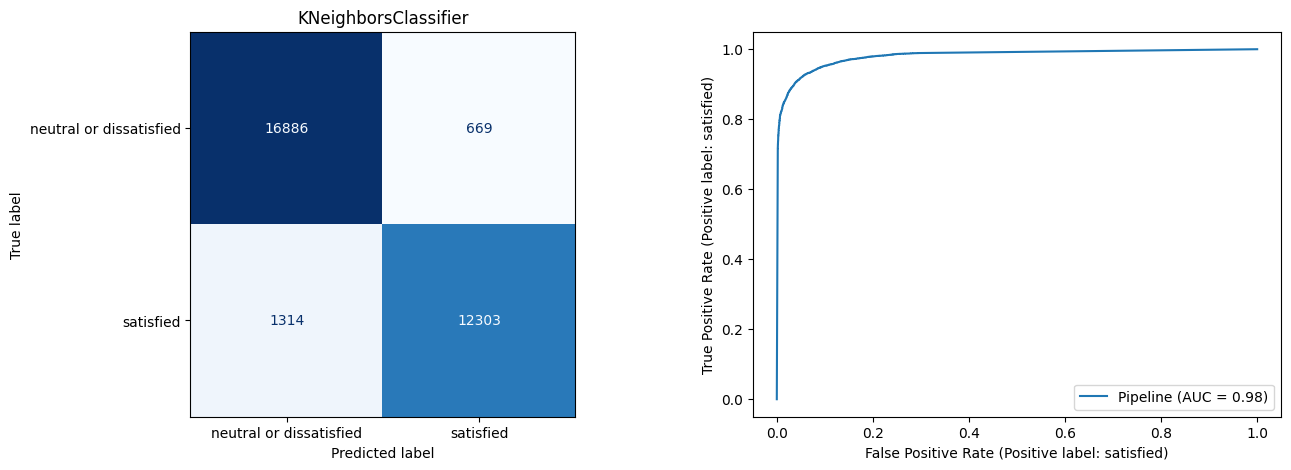

In [49]:
y_pred = knn.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(knn)

# SVM

In [50]:
pipe = Pipeline([("ct", ct), ("svm", LinearSVC(max_iter=3000))])
param_grid = {
    "svm__C": [0.001, 0.01, 0.1, 1, 10, 100]
}
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)
index = grid.best_index_
print(f"CV Mean score: {grid.best_score_}")

svm = grid.best_estimator_

{'svm__C': 0.1}
CV Mean score: 0.873563176045457


Test Accuracy: 0.8739253175927114
                         precision    recall  f1-score   support

neutral or dissatisfied       0.88      0.91      0.89     17555
              satisfied       0.87      0.83      0.85     13617

               accuracy                           0.87     31172
              macro avg       0.87      0.87      0.87     31172
           weighted avg       0.87      0.87      0.87     31172



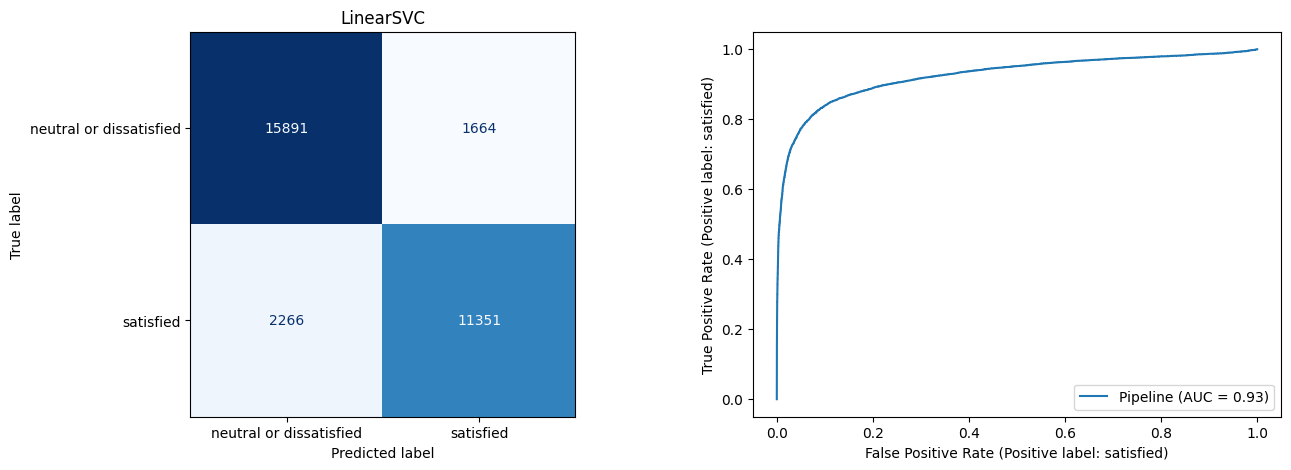

In [51]:
y_pred = svm.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(svm)

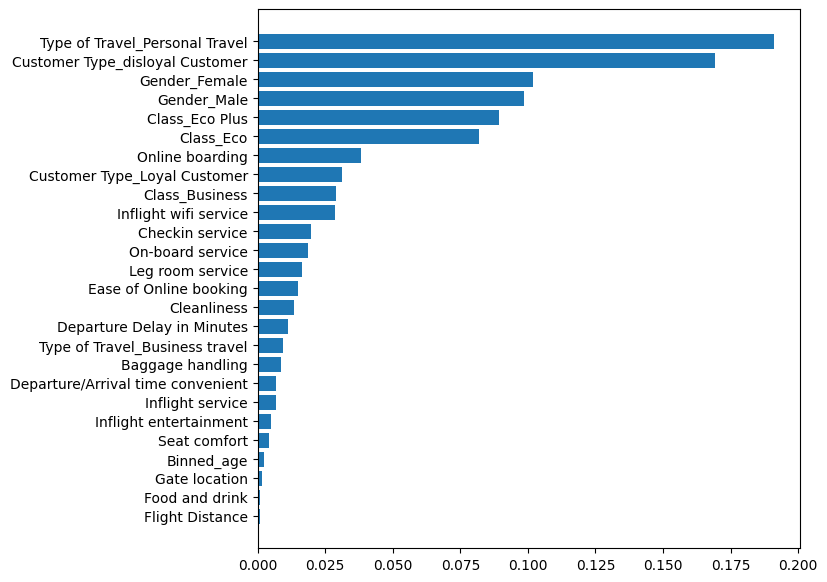

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
svm_weights = np.abs(svm[-1].coef_[0])
svm_weights /= svm_weights.sum()
idx = svm_weights.argsort()
ax.barh(range(len(idx)), svm_weights[idx])
ax.set_yticks(range(len(idx)), column_names[idx]);

# Rbf SVC

In [53]:
svc = Pipeline([("ct", ct), ("svm", SVC())])
scores = cross_val_score(svc, X_train, y_train, cv=10)
svc.fit(X_train, y_train)
print(f"CV Mean score: {scores.mean()}")

/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/iokonkwo2/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Li

CV Mean score: 0.9413188640014946


Test Accuracy: 0.9426408315154626
                         precision    recall  f1-score   support

neutral or dissatisfied       0.94      0.96      0.95     17555
              satisfied       0.95      0.92      0.93     13617

               accuracy                           0.94     31172
              macro avg       0.94      0.94      0.94     31172
           weighted avg       0.94      0.94      0.94     31172



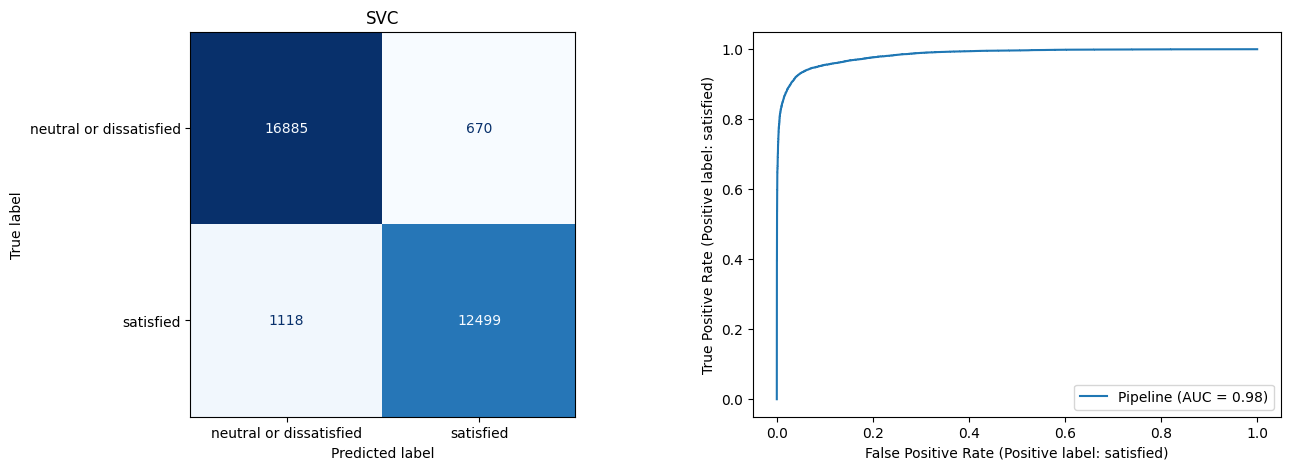

In [54]:
y_pred = svc.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(svc)

# ExtraTrees Classifier

In [55]:
pipe = Pipeline([("ct", ct), ("et", ExtraTreesClassifier(random_state=seed))])

param_grid = {
    "et__n_estimators": [100, 150, 200],
    "et__criterion": ["gini", "entropy"]
}
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

et_clf = grid.best_estimator_
index = grid.best_index_
print(f"CV Mean score: {grid.best_score_}")

{'et__criterion': 'entropy', 'et__n_estimators': 200}
CV Mean score: 0.9608012936385932


Test Accuracy: 0.9608302322597203
                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.98      0.97     17555
              satisfied       0.97      0.94      0.95     13617

               accuracy                           0.96     31172
              macro avg       0.96      0.96      0.96     31172
           weighted avg       0.96      0.96      0.96     31172



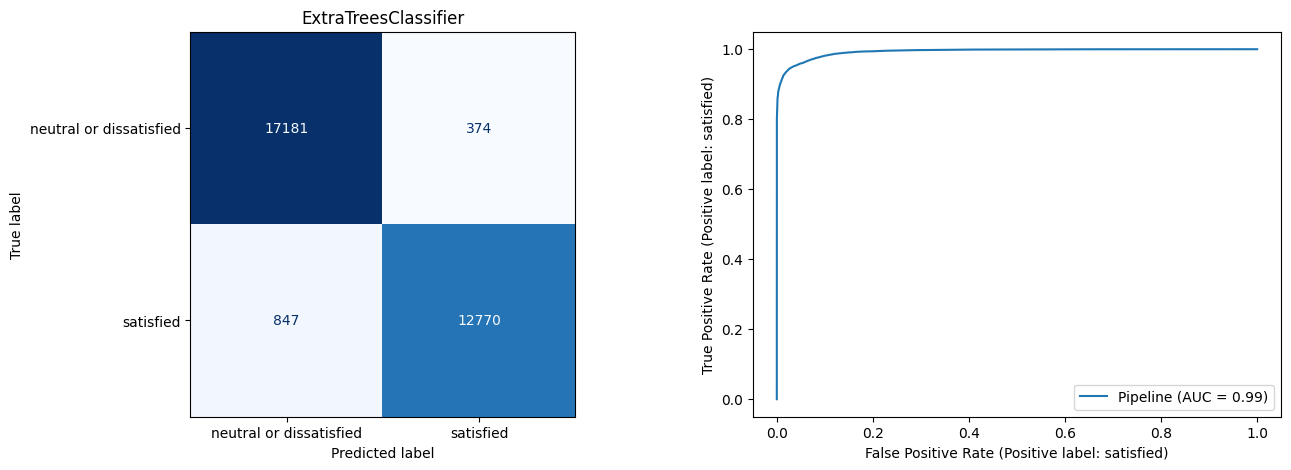

In [56]:
y_pred = et_clf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(et_clf)

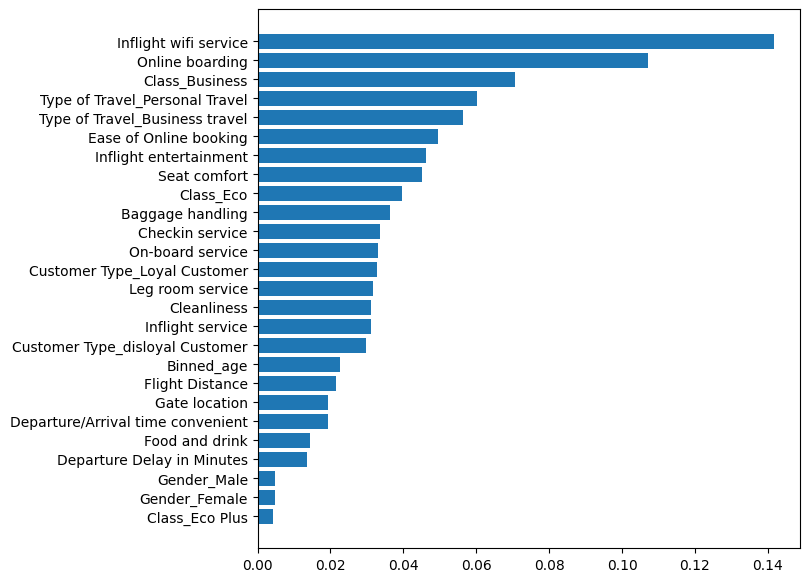

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
importance = et_clf[-1].feature_importances_
idx = importance.argsort()
ax.barh(range(len(idx)), importance[idx])
ax.set_yticks(range(len(idx)), column_names[idx]);

# MLP

In [32]:
mlp = Pipeline([("ct", ct), ("mlp", MLPClassifier())])
scores = cross_val_score(mlp, X_train, y_train, cv=10)
mlp.fit(X_train, y_train)
print(f"CV Mean score: {scores.mean()}")

CV Mean score: 0.9583127862908606


Test Accuracy: 0.9575580649300655
                         precision    recall  f1-score   support

neutral or dissatisfied       0.94      0.98      0.96     17555
              satisfied       0.98      0.93      0.95     13617

               accuracy                           0.96     31172
              macro avg       0.96      0.95      0.96     31172
           weighted avg       0.96      0.96      0.96     31172



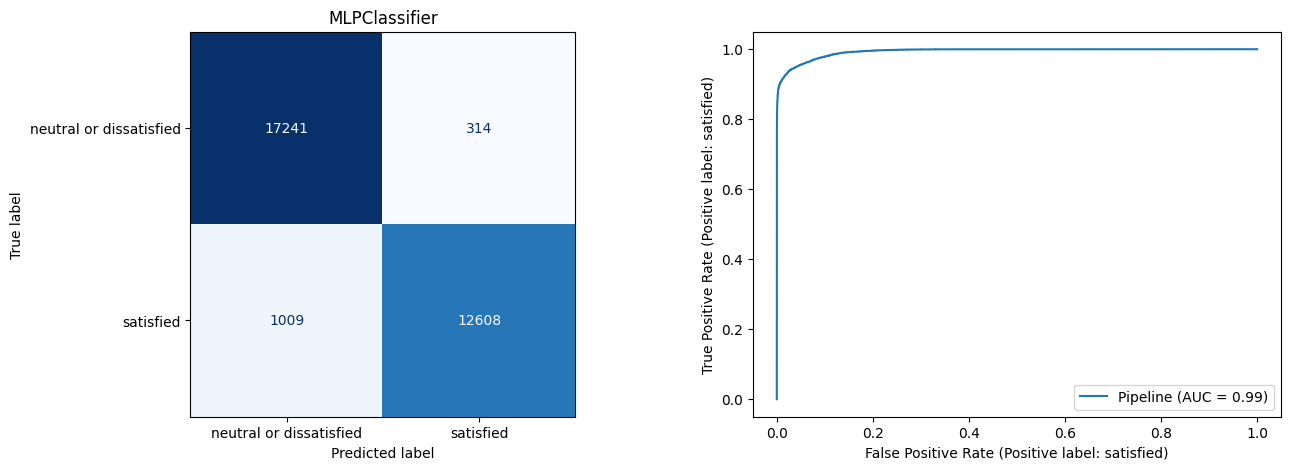

In [33]:
y_pred = mlp.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(mlp)

# Gradient Boosting

In [36]:
pipe = Pipeline([("ct", ct), ("grb", GradientBoostingClassifier(random_state=seed))])

param_grid = {
    "grb__criterion": ["friedman_mse", "squared_error"],
    "grb__loss": ["log_loss", "deviance", "exponential"],
    "grb__n_estimators": np.arange(200, 1000, 200)
}
grid = GridSearchCV(pipe, param_grid, cv=10, n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_)

grb = grid.best_estimator_
index = grid.best_index_
print(f"CV Mean score: {grid.best_score_}")

{'grb__criterion': 'friedman_mse', 'grb__loss': 'log_loss', 'grb__n_estimators': 800}
CV Mean score: 0.9594539443497843


Test Accuracy: 0.9583921467984088
                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.98      0.96     17555
              satisfied       0.97      0.94      0.95     13617

               accuracy                           0.96     31172
              macro avg       0.96      0.96      0.96     31172
           weighted avg       0.96      0.96      0.96     31172



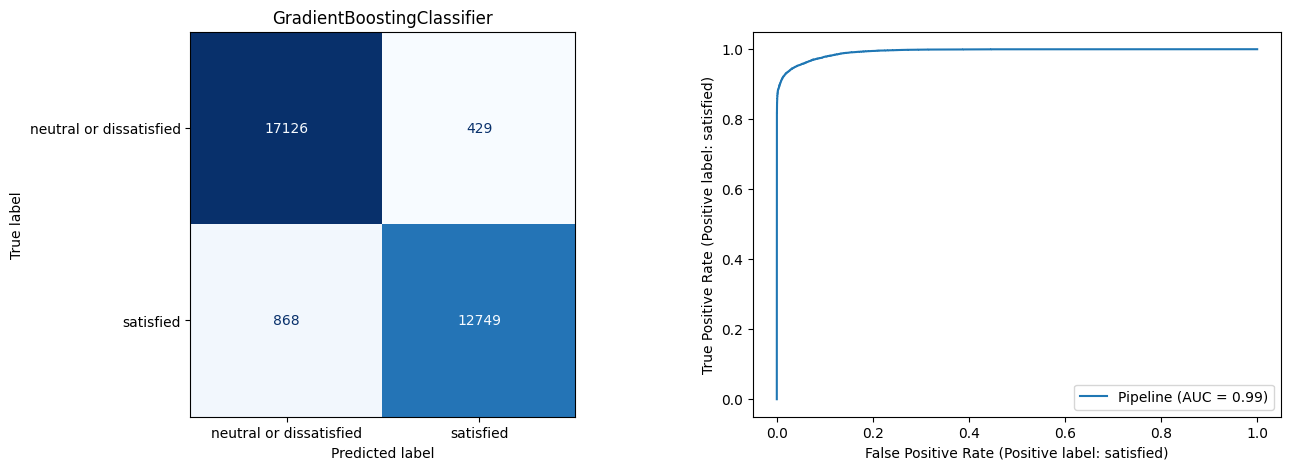

In [37]:
y_pred = grb.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(grb)

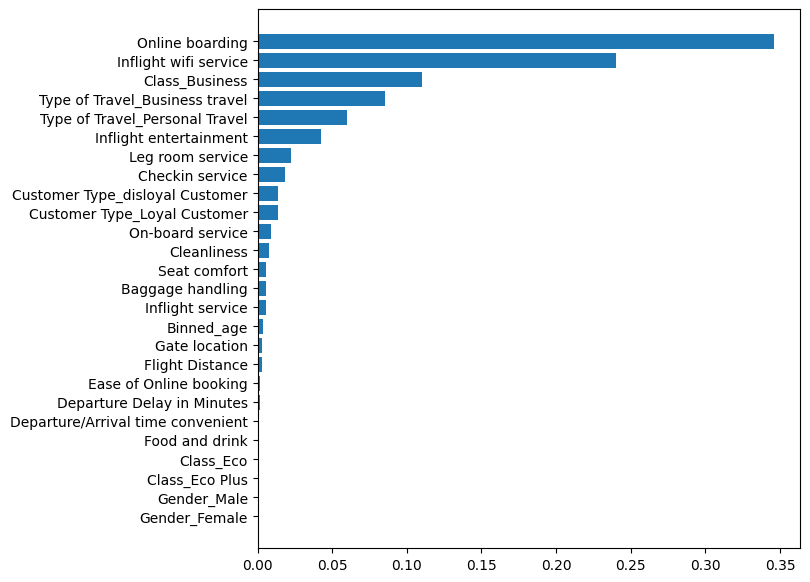

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
importance = grb[-1].feature_importances_
idx = importance.argsort()
ax.barh(range(len(idx)), importance[idx])
ax.set_yticks(range(len(idx)), column_names[idx]);

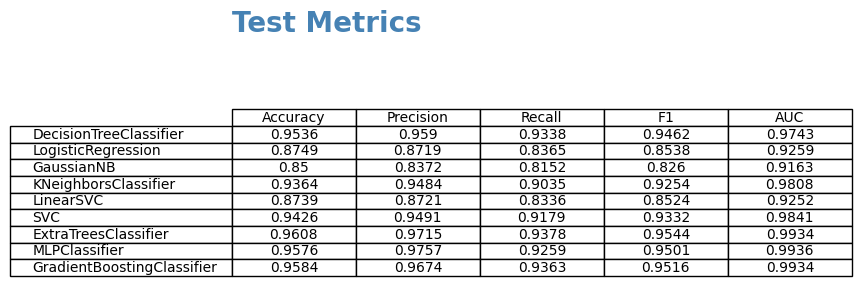

In [58]:
best_models = [dt_clf, lr_clf, gnb, knn, svm, svc, et_clf, mlp, grb]
df = display_test_metrics(best_models)

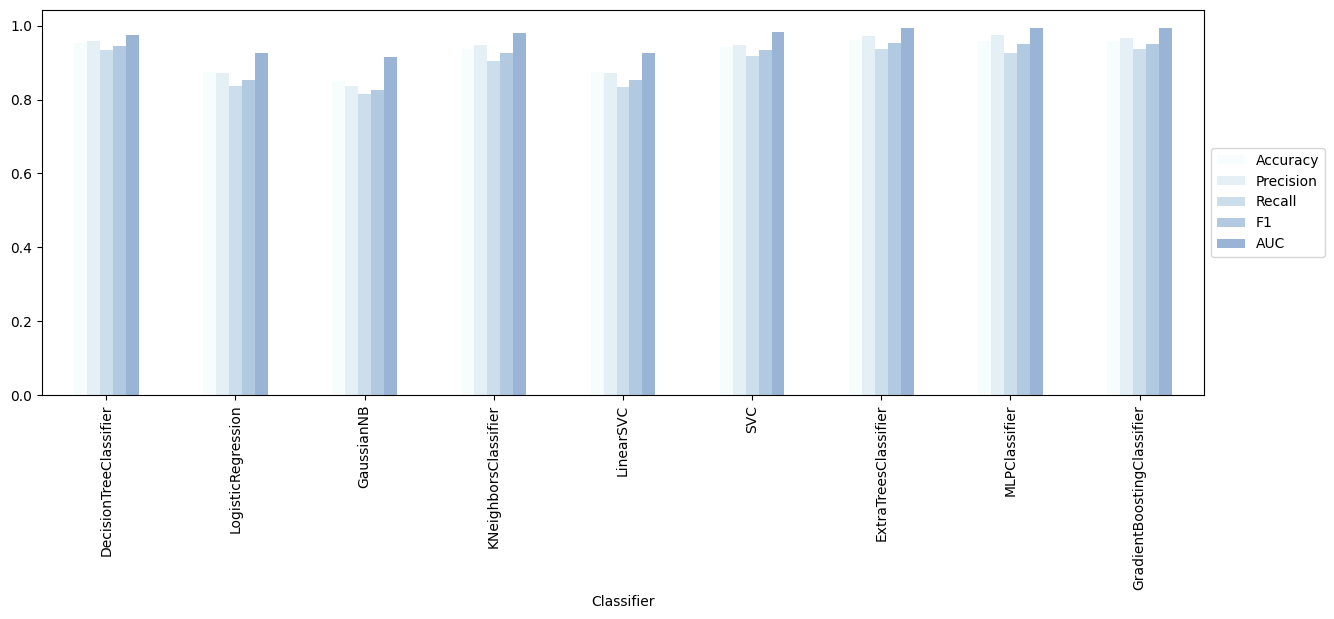

In [59]:
fig, axs = plt.subplots(1, 1, figsize=(15,5))
df.plot.bar(ax=axs, color = plt.cm.BuPu(np.linspace(0, 0.8, df.shape[0])))
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5));